In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import time
import pandas as pd
plt.rcParams["figure.figsize"] = (3,3)

print (time.ctime())

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Fri Apr 16 10:47:25 2021


In [2]:
# read a data file, store all data in arrays

file = "02_cent.csv"

print (file, time.ctime())
data = np.loadtxt(file, dtype= float, delimiter=",", usecols = (0,1,2,3,4,5,6,7,8,9,10,11))


#print data
tid = data[:, 0]    #
tt  = data[:, 1]    #trigger time
y   = data[:, 2]    #y-coordinate
x   = data[:, 3]    #x-coordinate
t   = data[:, 4]    #time of arrival
a   = data[:, 5]    #centroided data (flux of brightest pixel)
A   = data[:, 6]    #centroided data (flux of cluster)
tof = data[:, 7]    #time of flight
n   = data[:, 8]    #pixels in cluster (centroided data)
yc  = data[:, 9]    #corrected y
xc  = data[:, 10]   #corrected x
tof_corr = data[:, 11]*1000     #corrected time of flight

fileCorrection = "fourions_trigger100kHz_300s_W0028_H11-200211-192509-1_LTcorr.csv"
correction = np.loadtxt(fileCorrection, unpack=True, delimiter=",")
TOT_i  = [int(tot/25) for tot in a]
t_corr = t/4096*25 + correction[1][TOT_i]*1000  ### WAS CHANGED FROM ORIGINAL
tof_corr = tof/4096*25 #+ correction[1][TOT_i]*1000   ### WAS CHANGED FROM ORIGINAL
tt_corr = tt/4096*25                                 ###TT TIME CONVERSION TO (ns)

02_cent.csv Fri Apr 16 10:47:25 2021


In [3]:
data_table = pd.read_csv(file)                                                                       #Create Pandas Table
data_table.rename(columns = {'#TrigId':'tid', '#TrigTime':'tt', '#Col':'x', '#Row':'y', '#ToA':'time', '#ToT[arb]':'center flux', '#ToTtotal[arb]':'cluster flux'}, inplace=True)                    #Rename Columns
data_table.rename(columns = {'#Trig-ToA[arb]':'tof', '#Centroid':'cluster size', '#cent_X':'xc', '#cent_Y':'yc', '#cTrig-ToA[us]':'tof_corr'}, inplace=True)
data_table.drop(columns = {'Unnamed: 14', 'tid',  '#centStdev_X', '#centStdev_Y', '#centStdev_ToA'}, inplace=True)   #Remove unwanted columns
data_table['tof'] = tof_corr                                   ####SWAP OUT CORRECTED VALUES FOR TOF
data_table['tot-i'] = TOT_i
period = 82.77
data_table['tfold'] = (data_table['tof'] + 30)%period       #54.789717
real_time = ((t_corr - t_corr.min()))                          #SWAP OUT CORRECTED VALUES AND START TOA AT ZERO.
data_table['time'] = real_time   
real_tt = ((tt_corr - t_corr.min()))                            #tt translation to match zeroing of TOA
data_table['tt'] = real_tt
data_table

,tt,x,y,time,center flux,cluster flux,tof,cluster size,xc,yc,tot-i,tfold
0,-6.672326e+03,231,167,0.000000e+00,2775,4925,6673.962402,5,231.515228,167.525381,111,82.362402
1,3.427674e+03,148,168,6.885053e+03,1250,2150,3461.462402,3,148.313953,168.267442,50,15.122402
2,3.427674e+03,127,36,6.979158e+03,2000,3575,3553.649902,4,127.765734,36.758741,80,24.539902
3,1.352820e+04,62,131,1.651357e+04,2050,3825,2987.500000,5,62.179739,131.617647,82,37.780000
4,1.352820e+04,109,166,1.656774e+04,1650,2925,3042.187500,4,109.559829,166.192308,66,9.697500
...,...,...,...,...,...,...,...,...,...,...,...,...
1533132,5.067654e+09,92,128,5.067655e+09,1725,3450,804.687500,4,92.681159,128.108696,69,6.987500
1533133,5.067654e+09,147,166,5.067657e+09,1250,2825,2687.500000,4,147.075221,166.712389,50,68.860000
1533134,5.067654e+09,93,180,5.067659e+09,575,6800,4779.687500,8,93.125000,180.871324,23,9.027500
1533135,5.067654e+09,95,145,5.067661e+09,2275,4275,7021.875000,5,95.640351,145.184211,91,16.425000


In [18]:
#data_table.to_csv('2D_Micromotion')

In [19]:
data_table['tof'].max()

10100.78125

In [7]:
m = (data_table
     .query("tof<0")
    )
m
data_table = data_table.query('1.2e9 < time < 2.5e9')

(110.0, 200.0)

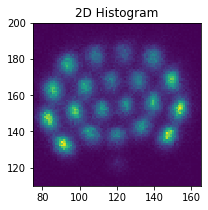

In [18]:
plt.hist2d(data_table['xc'], data_table['yc'], bins = 256,)# norm = mpl.colors.LogNorm())
plt.title('2D Histogram')
plt.xlim(75, 165)
plt.ylim(110, 200)

(149.0, 161.0)

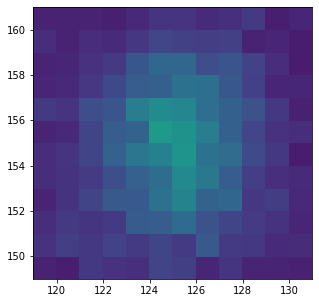

In [90]:
# This cell is used to see an image of the ions. Helpful to make sure ions did not move (blurry) and that there weren't spatial errors 
# Helpful also to identify the locaitons of the ions.
plt.figure(figsize=(5, 5))
it = data_table
plt.hist2d(it['xc'], it['yc'], bins = (256, 256), range = [(0,256), (0, 256)],)# norm = mpl.colors.LogNorm())
x_guess = x20
y_guess = y20
plt.xlim(x_guess-6,x_guess+6)
plt.ylim(y_guess-6, y_guess+6)


In [69]:
x1 = 91; y1 = 133
x2 = 83; y2 = 147
x3 = 85; y3 = 163
x4 = 93; y4 = 177
x5 = 109; y5 = 181
x6 = 124; y6 = 182
x7 = 139; y7 = 180
x8 = 149; y8 = 168
x9 = 153; y9 = 152
x10 = 147; y10 = 137
x11 = 105; y11 = 139
x12 = 97; y12 = 151
x13 = 103; y13 = 164
x14 = 117; y14 = 168
x15 = 131; y15 = 167
x16 = 139; y16 = 156
x17 = 133; y17 = 142
x18 = 120; y18 = 138
x19 = 112; y19 = 152
x20 = 125; y20 = 155

(array([13461., 13025., 13565., 13574., 13927., 13942., 14340., 14533.,
        14688., 15102., 15081., 15571., 15737., 16193., 16610., 17102.,
        16978., 17802., 17387., 17963., 18179., 18305., 18374., 18572.,
        18491., 18949., 18744., 18414., 18498., 18354., 18499., 18129.,
        18248., 17474., 17686., 17146., 16990., 17089., 16770., 16158.,
        16261., 15830., 15636., 15459., 15102., 14876., 14200., 14559.,
        14140., 14038., 13924., 13751., 13733., 13669., 13454., 13505.,
        13429., 13674., 13528., 13615., 13606., 13969., 14028., 14093.,
        14252., 14589., 14858., 14550., 14898., 15345., 15413., 15085.,
        15631., 15599., 15719., 15813., 15656., 15673., 15405., 15440.,
        15456., 15269., 15132., 15087., 14692., 14847., 14289., 14625.,
        13932., 14143., 13781., 13666., 13475., 13371., 13336., 13298.,
        13489., 12956., 13389., 13249.]),
 array([1.15234375e-03, 8.28840332e-01, 1.65652832e+00, 2.48421631e+00,
        3.31190430e+00

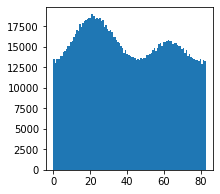

In [28]:
plt.hist(data_table['tfold'], bins = 100)